# Least Core for Data Valuation

This notebook introduces Least Core methods for the computation of data value using pyDVL.

The Least Core is the solution to the following linear programming problem:

$$
\begin{array}{lll}
\text{minimize} & \displaystyle{e} & \\
\text{subject to} & \displaystyle\sum_{i\in N} x_{i} = v(N) & \\
& \displaystyle\sum_{i\in S} x_{i} + e \geq v(S) &, \forall S \subseteq N \\
\end{array}
$$

Its use for Data Valuation was first desribed in the paper [*If You Like Shapley Then You’ll Love the Core*](https://ojs.aaai.org/index.php/AAAI/article/view/16721) by Tom Yan and Ariel D. Procaccia.

To illustrate this method we will use a synthetic dataset.

We will first a subset of 10 data instances to compute the exact values and use them to assess the monte carlo approximation.

Afterwards, we will conduct the data removal experiments as described by Ghorbani and Zou in their paper [Data Shapley: Equitable Valuation of Data for Machine Learning](https://arxiv.org/abs/1904.02868v1).

## Setup

We begin by importing the main libraries and setting some defaults.

<div class="alert alert-info">
If you are reading this in the documentation, some boilerplate has been omitted for convenience.
</div>

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import logging
import os
import random
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"] = (20, 8)
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 10

random_state = 16
random.seed(random_state)
np.random.seed(random_state)

is_CI = os.environ.get("CI")

if is_CI:
    enable_cache = False
    train_size = 10
else:
    enable_cache = True
    train_size = 200

We will be using the following functions and classes from pyDVL.

In [3]:
%autoreload
from pydvl.utils import (
    Dataset,
    Utility,
)
from pydvl.value.least_core import exact_least_core, montecarlo_least_core
from pydvl.reporting.plots import shaded_mean_std
from pydvl.reporting.scores import compute_removal_score, compute_random_removal_score

## Dataset

We will use a synthetic dataset. We sample 200 data points from a 50-dimensional Gaussian distribution.

The dataset is generated using the [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function from scikit-learn.

In [4]:
X, y = make_classification(
    n_samples=200,
    n_features=50,
    n_informative=25,
    n_classes=3,
    random_state=random_state,
)

In [5]:
full_dataset = Dataset.from_arrays(
    X, y, stratify_by_target=True, random_state=random_state
)
small_dataset = Dataset.from_arrays(
    X,
    y,
    stratify_by_target=True,
    train_size=10,
    random_state=random_state,
)

In [6]:
model = LogisticRegression(max_iter=500, solver="liblinear")

In [7]:
model.fit(full_dataset.x_train, full_dataset.y_train)
print(
    f"Training accuracy: {100 * model.score(full_dataset.x_train, full_dataset.y_train):0.2f}%"
)
print(
    f"Testing accuracy: {100 * model.score(full_dataset.x_test, full_dataset.y_test):0.2f}%"
)

Training accuracy: 86.25%
Testing accuracy: 70.00%


In [8]:
model.fit(small_dataset.x_train, small_dataset.y_train)
print(
    f"Training accuracy: {100 * model.score(small_dataset.x_train, small_dataset.y_train):0.2f}%"
)
print(
    f"Testing accuracy: {100 * model.score(small_dataset.x_test, small_dataset.y_test):0.2f}%"
)

Training accuracy: 100.00%
Testing accuracy: 47.89%


## Estimating Exact Least Core Values

In this first section we will use a smaller subset of the dataset containing 10 samples in order to be able to compute exact values in a reasonable amount of time. Afterwards, we will use the Monte Carlo method with a limited budget (maximum number of subsets) to approximate these values.

In [9]:
utility = Utility(model=model, data=small_dataset, enable_cache=False)

In [10]:
%%time
exact_values = exact_least_core(
    u=utility,
    progress=True,
)
exact_values_df = exact_values.to_dataframe(column="exact_value")
exact_values_df = exact_values_df.T
exact_values_df = exact_values_df[sorted(exact_values_df.columns)]
exact_values_df

  0%|          | 0/1023 [00:00<?, ?it/s]

CPU times: user 5.44 s, sys: 11.5 s, total: 17 s
Wall time: 2.58 s


,0,1,2,3,4,5,6,7,8,9
exact_value,0.04,0.031579,0.086842,0.053158,0.028947,0.04,0.057895,0.047895,0.037368,0.055263
exact_value_stderr,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000


In [11]:
%%time
budget_array = np.linspace(200, 2 ** (len(small_dataset) - 1), num=10, dtype=int)

all_estimated_values_df = []
all_errors = {}

for budget in budget_array:
    dfs = []
    errors = []
    for i in range(30):
        estimated_values = montecarlo_least_core(
            u=utility,
            max_iterations=budget,
            progress=False,
        )
        df = estimated_values.to_dataframe(column=f"estimated_value_{budget}")
        df = df[[x for x in df.columns if "stderr" not in x]]
        df = df.T
        df = df[sorted(df.columns)]
        error = mean_squared_error(
            exact_values_df.loc["exact_value"].values, df.values[0]
        )
        errors.append(error)
        df["budget"] = budget
        dfs.append(df)
    all_errors[budget] = errors
    estimated_values_df = pd.concat(dfs)
    all_estimated_values_df.append(estimated_values_df)

values_df = pd.concat(all_estimated_values_df)
errors_df = pd.DataFrame(all_errors)

CPU times: user 15.7 s, sys: 1.13 s, total: 16.8 s
Wall time: 2min 39s


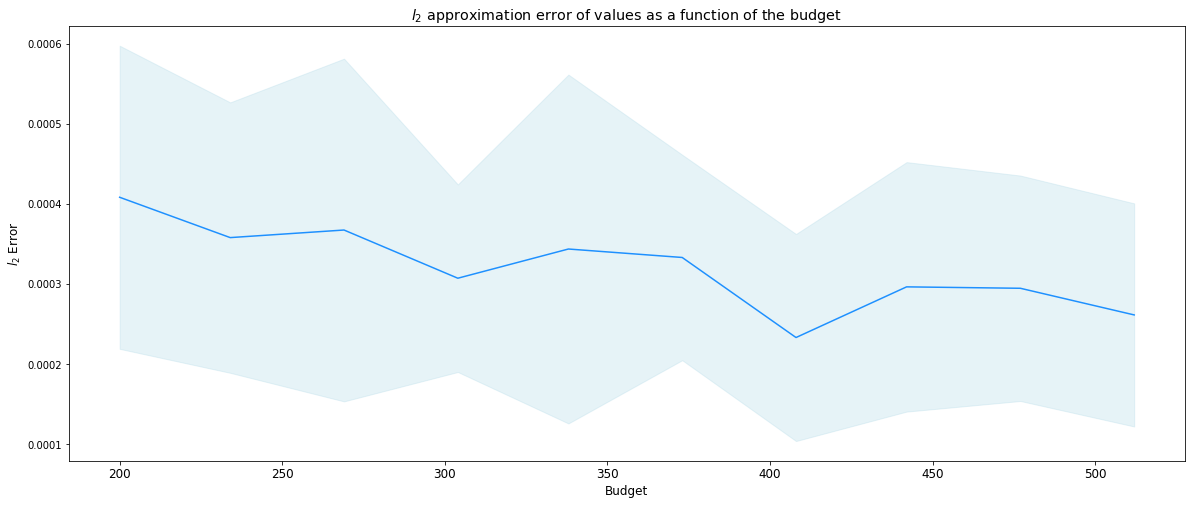

In [12]:
ax = shaded_mean_std(
    errors_df,
    abscissa=errors_df.columns,
    num_std=1,
    xlabel="Budget",
    ylabel="$l_2$ Error",
    label="Estimated values",
    title="$l_2$ approximation error of values as a function of the budget",
)

We can see that the approximation error decreases as the we increase the budget. 

Still, the decrease does not necessarily happen when we increase the number of iterations because of the fact that we sample the subsets with replacement in the Monte Carlo method i.e there may be repeated subsets.

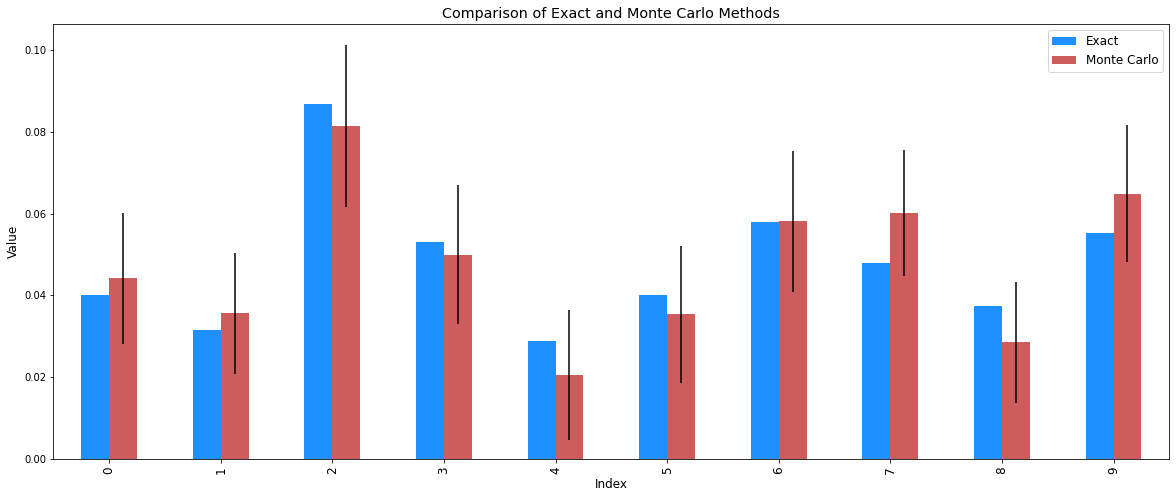

In [13]:
mean_std_values_df = values_df.drop(columns="budget").agg(["mean", "std"])
pd.concat([exact_values_df, mean_std_values_df]).T.plot(
    kind="bar",
    title="Comparison of Exact and Monte Carlo Methods",
    xlabel="Index",
    ylabel="Value",
    color=["dodgerblue", "indianred"],
    y=["exact_value", "mean"],
    yerr=[exact_values_df.loc["exact_value_stderr"], mean_std_values_df.loc["std"]],
)
plt.legend(["Exact", "Monte Carlo"]);

## Data Removal

We now move on to the data removal experiments using the full dataset.

In this set of experiments, the data instances are ranked from most valuable 
to least valuable using the Monte Carlo Least Core method, 
then we gradually remove 5 percent of the most valuable/least valuable ones,
train the model on this subset and compute its accuracy.

In [14]:
utility = Utility(model=model, data=full_dataset, enable_cache=False)

In [15]:
budget_array = ["Random", 5000, 10000, 25000, 50000]
removal_percentages = np.arange(0, 0.41, 0.05)

In [17]:
mean_colors = ["dodgerblue", "indianred", "limegreen", "darkorange", "darkorchid"]
shade_colors = ["lightskyblue", "firebrick", "seagreen", "gold", "plum"]

### Remove Best

We start by removing the best data instances and seeing how the model's accuracy evolves.

In [18]:
%%time
all_scores = []

for budget in budget_array:
    for i in range(5):
        if budget == "Random":
            scores = compute_random_removal_score(
                u=utility, percentages=removal_percentages
            )
        else:
            values = montecarlo_least_core(
                u=utility,
                max_iterations=budget,
                progress=False,
            )
            scores = compute_removal_score(
                u=utility,
                values=values,
                percentages=removal_percentages,
            )
        scores["budget"] = budget
        all_scores.append(scores)

scores_df = pd.DataFrame(all_scores)

(wrapper pid=924734) E1231 22:46:36.742212483  930254 chttp2_transport.cc:1111]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"
(wrapper pid=924738) E1231 22:46:36.745077470  924738 chttp2_transport.cc:1111]   Received a GOAWAY with error code ENHANCE_YOUR_CALM and debug data equal to "too_many_pings"


CPU times: user 3min 42s, sys: 12.8 s, total: 3min 55s
Wall time: 53min 18s


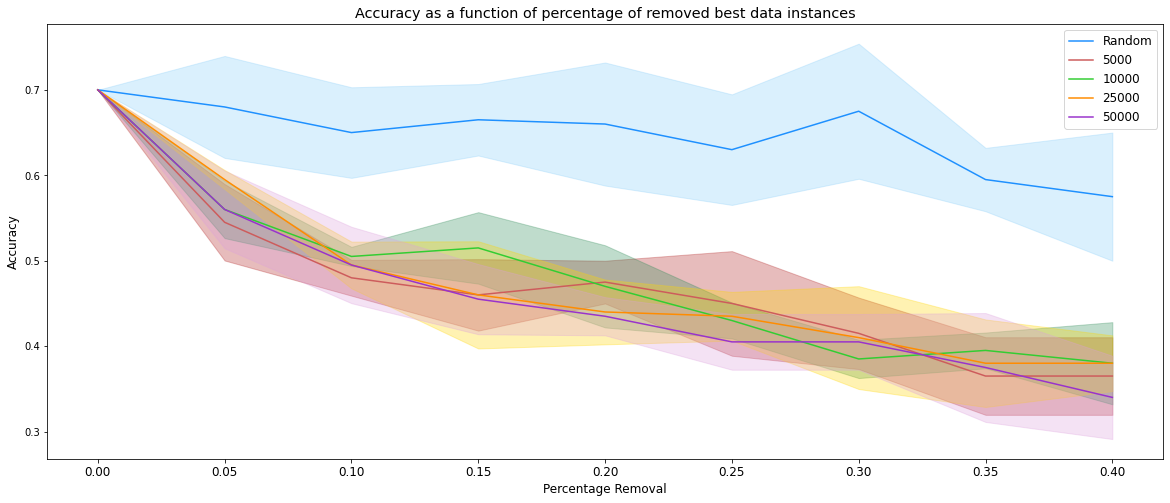

In [19]:
fig, ax = plt.subplots()

for i, budget in enumerate(budget_array):
    _ = shaded_mean_std(
        scores_df[scores_df["budget"] == budget].drop(columns=["budget"]),
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        xlabel="Percentage Removal",
        ylabel="Accuracy",
        label=f"{budget}",
        title="Accuracy as a function of percentage of removed best data instances",
        ax=ax,
    )

plt.legend();

We can clearly see that removing the most valuable data instances, as given by the Least Core method, leads to a decrease in the model's performance.

We can also see that as we increase the method's budget the estimation improves and this leads in turn to a bigger decrease in accuracy.

### Remove Worst

We then proceed to removing the worst data instances and seeing how the model's accuracy evolves.

In [20]:
%%time
all_scores = []

for budget in budget_array:
    for i in range(5):
        if budget == "Random":
            scores = compute_random_removal_score(
                u=utility, percentages=removal_percentages
            )
        else:
            values = montecarlo_least_core(
                u=utility,
                max_iterations=budget,
                progress=False,
            )
            scores = compute_removal_score(
                u=utility,
                values=values,
                percentages=removal_percentages,
                remove_best=False,
            )
        scores["budget"] = budget
        all_scores.append(scores)

scores_df = pd.DataFrame(all_scores)

CPU times: user 3min 7s, sys: 10.2 s, total: 3min 17s
Wall time: 46min 10s


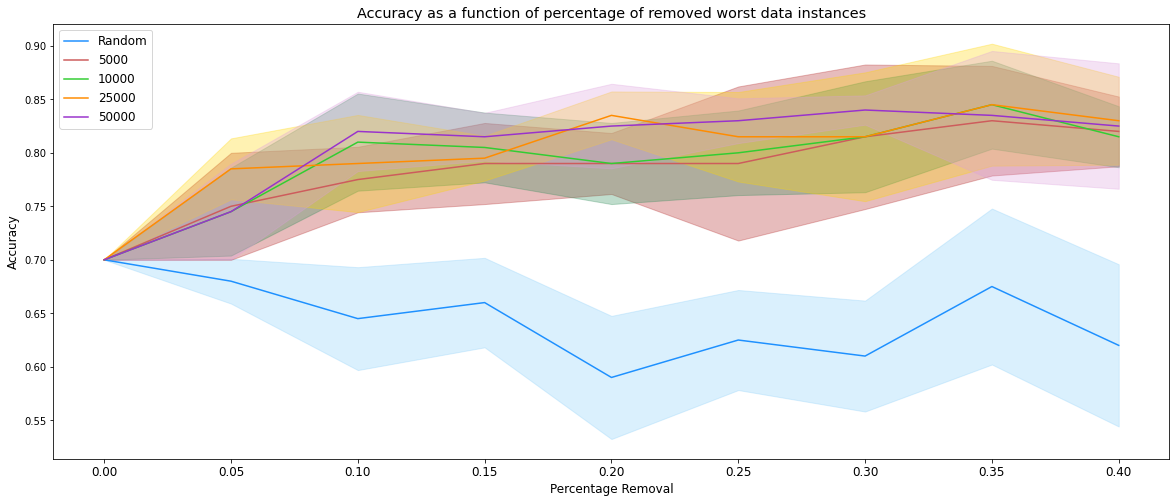

In [21]:
fig, ax = plt.subplots()

for i, budget in enumerate(budget_array):
    _ = shaded_mean_std(
        scores_df[scores_df["budget"] == budget].drop(columns=["budget"]),
        abscissa=removal_percentages,
        mean_color=mean_colors[i],
        shade_color=shade_colors[i],
        xlabel="Percentage Removal",
        ylabel="Accuracy",
        label=f"{budget}",
        title="Accuracy as a function of percentage of removed worst data instances",
        ax=ax,
    )
plt.legend();

We can clearly see that removing the least valuable data instances, as given by the Least Core method, leads to an increase in the model's performance.

We can also see that as we increase the method's budget the estimation improves and this leads in turn to a bigger increase in accuracy.